## CNN Cancer Detection Kaggle Mini-Project
A Jupyter notebook with a description of the problem/data, exploratory data analysis (EDA) procedure, analysis (model building and training), result, and discussion/conclusion. 

## Problem
In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

### Data
The data comes from Kaggle (https://www.kaggle.com/competitions/histopathologic-cancer-detection/data)

In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

### Load libraries

In [70]:
# Basic libraries
import pandas as pd
import numpy as np
import os

# Plots
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Data processing, metrics and modeling
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import PReLU
from keras.initializers import Constant

# Supress warning
import warnings
warnings.filterwarnings('ignore')

## 1. Exploratory Data Analysis (EDA)

### 1.1. Data import and basic inspection
Importing the data from the train_labels CSV file and inspecting its content.

In [3]:
# Read the training label data
train_labels = pd.read_csv('./data/histopathologic-cancer-detection/train_labels.csv')
display(train_labels.info(),train_labels.head(),train_labels.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


None

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Counting the number of training and testing image samples

In [4]:
# As I was unable to upload the testing images on my local Jupyter Notebook, I used the local path onmy computer
# where the images are stored.
train_dir = 'D:\\CL_Documents\Master Data Science\\Courses\\DTSA 5511 - Introduction to Deep Learning\\Week3\\Assignment\\train\\'
test_dir = 'D:\\CL_Documents\\Master Data Science\\Courses\\DTSA 5511 - Introduction to Deep Learning\\Week3\\Assignment\\test\\'

print(f"There is {len(os.listdir(test_dir))} training samples")
print(f"There is {len(os.listdir(train_dir))} testing samples")

There is 57458 training samples
There is 220025 testing samples


Determining the category distribution on the training data

In [5]:
# Create a copy of train_labels datagrame
train = train_labels.copy()

# Replace the labels with a more descriptive name
labelName = {0: 'Non-cancerous tissue', 1: 'Cancerous tissue'}
train.label.replace(labelName, inplace = True)

# Count per label
train_count_bef = train['label'].value_counts()
train_count_bef

Non-cancerous tissue    130908
Cancerous tissue         89117
Name: label, dtype: int64

Plot the distribution of categories to know if the data is balanced or not.

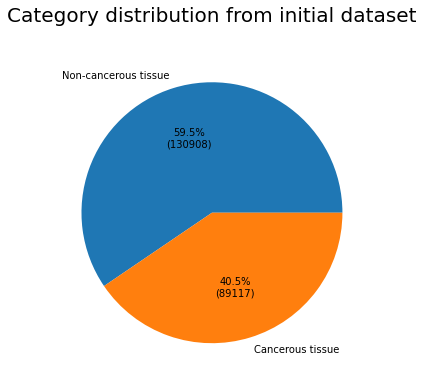

In [6]:
# Helper function from https://stackoverflow.com/questions/59644751/matplotlib-pie-chart-show-both-value-and-percentage
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{:.1f}%\n({v:d})'.format(pct, v=val)
    return my_format
    
categories = train_count_bef.index.tolist()
values = np.array(train_count_bef.values.tolist())

y = np.array(values)

plt.figure(figsize=(6, 6))
plt.pie(y, labels = categories, autopct=autopct_format(y))
plt.title('Category distribution from initial dataset\n', fontsize="20")
plt.show() 

### 1.2 Data preparation
From the previous step, we found out that the train dataset is imbalance becasue there are more images classified as Non-cancerous tissue than Cancerous tissue. To make the prediction more accurate, I will use Down/Under Sample Majority technique which is the process of randomly selecting samples of majority class and removing them in order to prevent them from dominating over the minority class in the dataset. 

In [7]:
# Dividing majority and minority classes
train_major = train[train.label=='Non-cancerous tissue']
train_minor = train[train.label=='Cancerous tissue']

# Down sampling majority class
train_major_sample = resample(train_major,
               replace=False,  # Down sample without replacement
               n_samples=train_minor.shape[0],   # Number to match minority class
               random_state=42)
  
# Combine down sampled majority class and minority class
train_balanced = pd.concat([train_major_sample, train_minor]).reset_index(drop=True)
   
# Display count of data points in both class
print(train_balanced.label.value_counts())

Non-cancerous tissue    89117
Cancerous tissue        89117
Name: label, dtype: int64


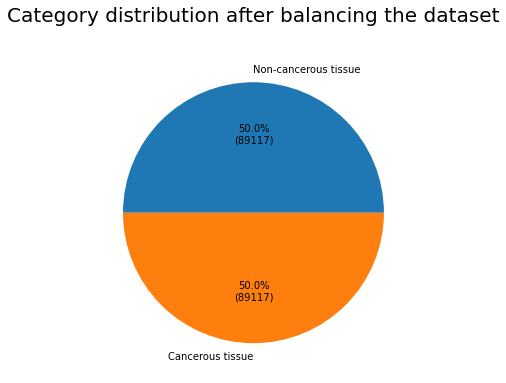

In [8]:
# Count per label
train_count_aft = train_balanced['label'].value_counts()
train_count_aft

categories = train_count_aft.index.tolist()
values = np.array(train_count_aft.values.tolist())

y = np.array(values)
plt.figure(figsize=(6, 6))
plt.pie(y, labels = categories, autopct=autopct_format(y))
plt.title('Category distribution after balancing the dataset\n', fontsize="20")
plt.show() 

After the technique has been applied, we can see that the data is balance now.

### 1.3 Printing images

'Non-cancerous tissue'

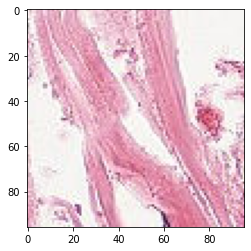

In [9]:
# Getting the first image on the balanced set
path = "{0}{1}.tif".format(train_dir, train_balanced.iloc[0,0] )
img = mpimg.imread(path)
imgplot = plt.imshow(img)
train_balanced.iloc[0,1]

In [10]:
# Get image size
print(img.shape)

(96, 96, 3)


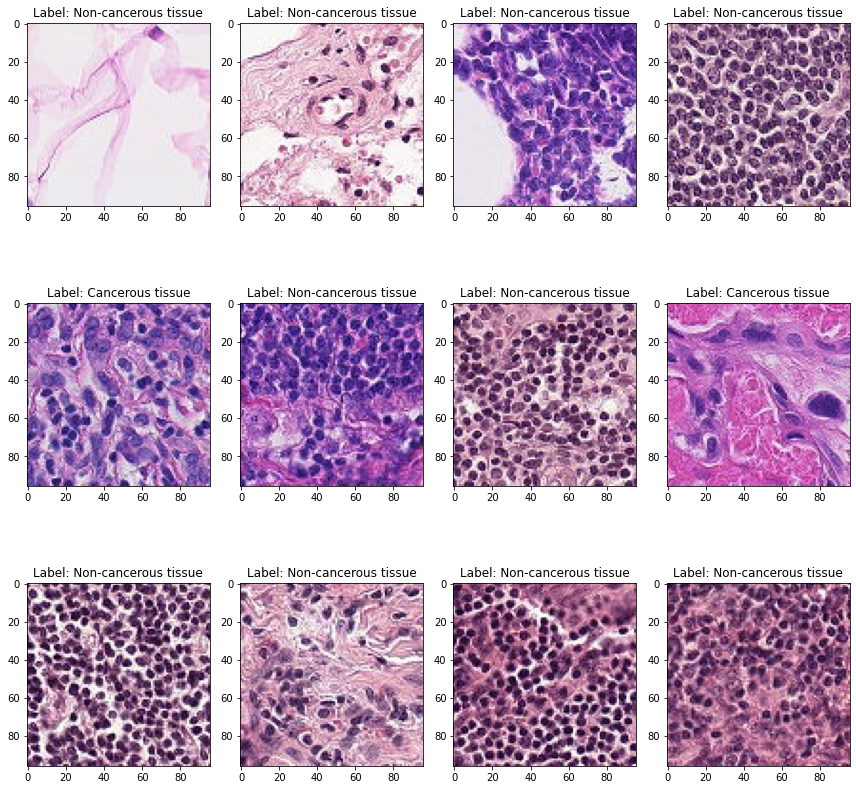

In [11]:
# RAndomly select 12 images
sample_imgs = np.random.choice(train_balanced.index,12)

fig, ax = plt.subplots(3, 4,figsize=(12,12))

for i in range(0, sample_imgs.shape[0]):
    ax = plt.subplot(3, 4, i+1)
    path = path = "{0}\\{1}.tif".format(train_dir, train_balanced.iloc[sample_imgs[i],0] )
    img = mpimg.imread(path)
    ax.imshow(img)
    lab = train_balanced.iloc[sample_imgs[i],1]
    ax.set_title('Label: %s'%lab)
    
plt.tight_layout()

The images are different from each other and it is difficult to know which images are non-cancerous and cancerous without the labels.

## 2. Model building, training and prediction

In [12]:
# Splitting the training set
train_df, valid_df = train_test_split(train_balanced, test_size=0.25, random_state=1234, 
                                      stratify=train_balanced.label)
# Adding the extension file of the images
train_df['id'] = train_df['id']+'.tif'
valid_df['id'] = valid_df['id']+'.tif'
# Converting data type of label
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

In [13]:
#create the training and validation subsets
train_datagen=ImageDataGenerator(rescale=1/255)

train_generator=train_datagen.flow_from_dataframe(dataframe=train_df,directory=train_dir,
                x_col="id",y_col="label",batch_size=64,seed=1234,shuffle=True,
                class_mode="binary",target_size=(96,96))

valid_generator=train_datagen.flow_from_dataframe(dataframe=valid_df,directory=train_dir,
                x_col="id",y_col="label",batch_size=64,seed=1234,shuffle=True,
                class_mode="binary",target_size=(96,96))

Found 133675 validated image filenames belonging to 2 classes.
Found 44559 validated image filenames belonging to 2 classes.


Create a basic CNN model

In [64]:
#model  with 4 convolutional layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img.shape[0], img.shape[1], img.shape[2])))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

opt = tf.keras.optimizers.Adam(0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_20 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                      

### 2.2 Training

In [85]:
STEP_SIZE_TRAIN

2088

In [21]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

modelfit = model.fit_generator(generator=train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,                    
                              validation_steps=STEP_SIZE_VALID,
                              epochs=30, verbose=1
)

Epoch 1/30
2088/2088 [==============================] - 979s 468ms/step - loss: 0.4391 - accuracy: 0.8277 - val_loss: 0.7340 - val_accuracy: 0.6951
Epoch 2/30
2088/2088 [==============================] - 940s 450ms/step - loss: 0.2777 - accuracy: 0.8869 - val_loss: 1.6519 - val_accuracy: 0.6445
Epoch 3/30
2088/2088 [==============================] - 904s 433ms/step - loss: 0.2195 - accuracy: 0.9133 - val_loss: 1.0319 - val_accuracy: 0.6171
Epoch 4/30
2088/2088 [==============================] - 1001s 480ms/step - loss: 0.1866 - accuracy: 0.9291 - val_loss: 3.2956 - val_accuracy: 0.6888
Epoch 5/30
2088/2088 [==============================] - 956s 458ms/step - loss: 0.1591 - accuracy: 0.9403 - val_loss: 0.2682 - val_accuracy: 0.8945
Epoch 6/30
2088/2088 [==============================] - 944s 452ms/step - loss: 0.1361 - accuracy: 0.9486 - val_loss: 0.8040 - val_accuracy: 0.7928
Epoch 7/30
2088/2088 [==============================] - 933s 447ms/step - loss: 0.1160 - accuracy: 0.9565 - val

### 2.3 Evaluation

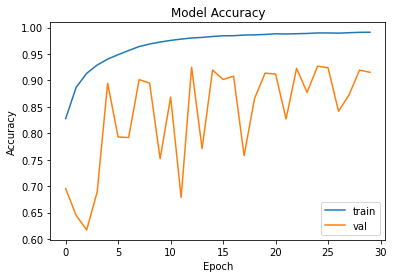

In [56]:
plt.plot(modelfit.history['accuracy'], label='train')
plt.plot(modelfit.history['val_accuracy'], label = 'val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

The basic CNN model reach an accuracy close to 100% at epoch number 20 and maintains like that until epoch number 30.

### 2.4 PReLU
Although I reached an accuracy of 99% at epoch number 28 on the basic CNN model, I will add PReLU (Parametric Rectified Linear Unit) to see if I am able to improve more the model. PReLU is an activation function that adaptively learns the parameters of the rectifiers, and improves accuracy at negligible extra computational cost.

In [71]:
#model  with 4 convolutional layers
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img.shape[0], img.shape[1], img.shape[2])))
model1.add(PReLU(alpha_initializer=Constant(value=0.25)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(BatchNormalization())

model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(PReLU(alpha_initializer=Constant(value=0.25)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(BatchNormalization())

model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(PReLU(alpha_initializer=Constant(value=0.25)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(BatchNormalization())

model1.add(Flatten())
model1.add(Dropout(0.2))
model1.add(Dense(512, activation = "relu"))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation = "sigmoid"))

opt = tf.keras.optimizers.RMSprop(0.001)
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 p_re_lu (PReLU)             (None, 96, 96, 32)        294912    
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_31 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 p_re_lu_1 (PReLU)           (None, 46, 46, 64)      

In [72]:
modeltune = model1.fit_generator(generator=train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,                    
                              validation_steps=STEP_SIZE_VALID,
                              epochs=30, verbose=1
)

Epoch 1/30
2088/2088 [==============================] - 1560s 746ms/step - loss: 0.4964 - accuracy: 0.8292 - val_loss: 1.1927 - val_accuracy: 0.7082
Epoch 2/30
2088/2088 [==============================] - 1519s 728ms/step - loss: 0.3121 - accuracy: 0.8746 - val_loss: 1.4035 - val_accuracy: 0.7926
Epoch 3/30
2088/2088 [==============================] - 1519s 727ms/step - loss: 0.2805 - accuracy: 0.8907 - val_loss: 0.3564 - val_accuracy: 0.8728
Epoch 4/30
2088/2088 [==============================] - 1524s 730ms/step - loss: 0.2651 - accuracy: 0.8993 - val_loss: 2.1162 - val_accuracy: 0.8471
Epoch 5/30
2088/2088 [==============================] - 1557s 746ms/step - loss: 0.2486 - accuracy: 0.9057 - val_loss: 0.5751 - val_accuracy: 0.8586
Epoch 6/30
2088/2088 [==============================] - 1564s 749ms/step - loss: 0.2359 - accuracy: 0.9118 - val_loss: 0.3182 - val_accuracy: 0.9022
Epoch 7/30
2088/2088 [==============================] - 1569s 751ms/step - loss: 0.2276 - accuracy: 0.9152

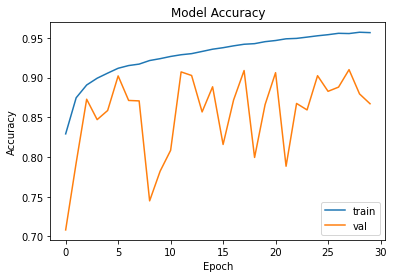

In [73]:
plt.plot(modeltune.history['accuracy'], label='train')
plt.plot(modeltune.history['val_accuracy'], label = 'val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### 2.5 Prediction
For the prediction, I will use the first model created because it got higher accuracy than the model created using PReLU activation function.

In [80]:
# create the test dataframe
test_set = os.listdir(test_dir)
test_df = pd.DataFrame(test_set)
test_df.columns = ['id']

# create the test subset
test_datagen=ImageDataGenerator(rescale=1/255)

test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,directory=test_dir,
                x_col="id",batch_size=64,seed=1234,shuffle=False,
                class_mode=None,target_size=(96,96))

Found 57458 validated image filenames.


In [89]:
test_df.shape

(57458, 1)

In [91]:
# generate the prediction
#STEP_SIZE_TEST=test_generator.n/2
preds = model1.predict_generator(generator=test_generator, verbose = 1)

898/898 [==============================] - 165s 184ms/step


In [87]:
# generate the labels with value 1 and 0
predictions = []

for pred in preds:
    if pred >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)
        
predictions[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [88]:
# generate the submission file
submission = test_df.copy()
submission['id']=submission['id'].str[:-4]
submission['label']=predictions
submission.head()
submission.to_csv('submission.csv',index=False)

## 3. Discussion

### 3.1 Conclusion

The initial architecture of the model uses a common pattern for the convolutional base which is a stack of Conv2D and MAxPooling2D with a Batch normalization method to make the training faster and more stable. Dropout is applied to cut too much association among features. Dense and flatten layers are added for model improvement. The accuracy of this model reached 99% at epoch number 28. Although the accuracy was almost 100%, I wanted to test if adding the PReLU activate function will reach the 100% but it didn't. The highest accuracy reached was 96%. Thus, I used the first model to predict the test data. During the prediction, I got an error by using the steps option. For fixing the issue, I needed to re-train the models again to change steps_per_epoch parameter for the model fit. However, training the model takes almost a day on my computer. Therefore, I decided to remove  the steps parameters on the prediction.

### 3.2 Future improvement
Tweak the steps_per_epoch parameter on the model and train again to see if it is possible to predict the number of test files divided by two.